# Extract Raster Values at Point Locations in Python

You will extract pixel values that cover each field plot area where trees were measured in the NEON Field Sites. The idea is that you can calculate the mean or max height value for all pixels that fall in each NEON site.

Then, you will compare that mean or max height value derived from the Lidar data derived canopy height model pixels to height values calculated using human tree height measurements.

To do this, you need to do the following:
1. Import the CHM that you wish to extract tree height data from.
2. Clean up that data. For instance if there are values of 0 for areas where there are no trees they will impact a mean value calculation. It is better to remove those values from the data.
3. Finally you will import and create a buffer zone that represents the area where trees were sampled in each NEON field site.

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd

# Rasterstats contains the zonalstatistics function
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

# Download data and set work dir
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

## Import CHM

## Context managers and Rasterio

Use a context manager with to create a connection to your raster dataset. This connection 

In [9]:
# Load & plot the data
sjer_lidar_chm_path = os.path.join("data", "spatial-vector-lidar", 
                                   "california", "neon-sjer-site", 
                                   "2013", "lidar", "SJER_lidarCHM.tif")

with rio.open(sjer_lidar_chm_path) as sjer_lidar_chm_src:
    # Masked = True sets no data values to np.nan if they are in the metadata
    SJER_chm_data = sjer_lidar_chm_src.read(1, masked=True)
    sjer_chm_meta = sjer_lidar_chm_src.profile

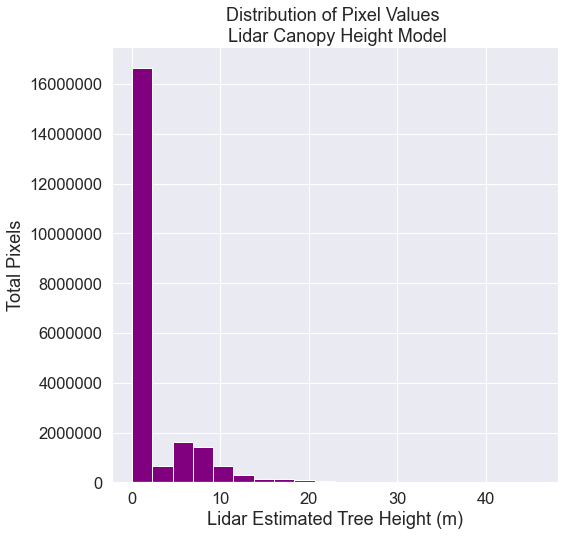

In [11]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(SJER_chm_data,
          figsize=(8, 8),
          colors="purple",
          xlabel="Lidar Estimated Tree Height (m)",
          ylabel="Total Pixels",
          title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax[1]. ticklabel_format(useOffset=False,
                       style="plain")

In [12]:
# EXPLORE: View summary statistics of CHM
# Notice the mean value with 0's included in the data
print("Mean:", np.nanmean(SJER_chm_data))
print("Max:", np.nanmax(SJER_chm_data))
print("Min:", np.nanmin(SJER_chm_data))

Mean: 1.9355862
Max: 45.879997
Min: 0.0


## Clean up data - remove 0s

Looking at the distribution of data, you can see there are many pixels that have a value of 0 - where there are no trees. Also, using the NEON data, values below 2m are normally set to 0 given the accuracy of the Lidar instrument used to collect these data.

Set all pixel values ==0 to nan as they will impact calculation of plot mean height. A mean calculated with values of 0 will be significantly lower than a mean calculated with just tree height values.

In [14]:
# CLEANUP: Set CHM values oif 0 to NaN (no data or not a number)
SJER_chm_data[SJER_chm_data == 0] = np.nan

# View summary stats of CHM after cleaning up the data
print("Mean:", np.nanmean(SJER_chm_data))
print("Max:", np.nanmax(SJER_chm_data))
print("Min:", np.nanmin(SJER_chm_data))

Mean: 8.213505
Max: 45.879997
Min: 2.0


c:\programdata\miniconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\programdata\miniconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


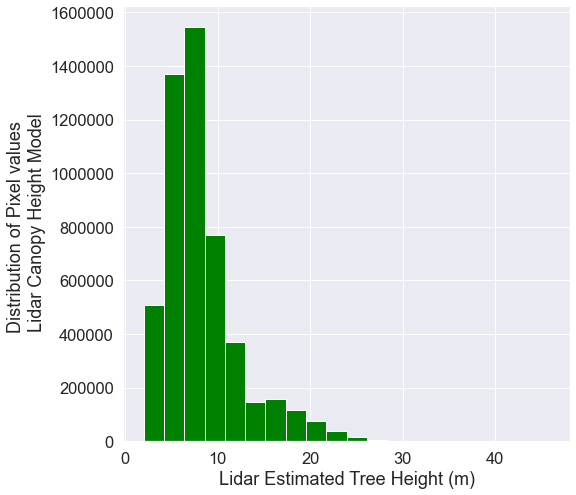

In [17]:
ax=ep.hist(SJER_chm_data,
          figsize=(8, 8),
          colors="green",
          xlabel="Lidar Estimated Tree Height (m)",
          ylabel="Distribution of Pixel values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                      style="plain")

## Import plot location data & create buffer

You now have a cleaned CHM for your study area. However, how do the height values extracted from the CHM compare to our manually collected, field measured CH data? Use insitu collected tree height data, measured within circular plots across our study area. You will compare the max measured tree height value to the max LIDAR derived height value for each circular plot using regression

1st, import the shapefile that contains the plot centroid (the centre point of each plot) locations using geopandas.

In [18]:
sjer_centroids_path = os.path.join("data", "spatial-vector-lidar",
                                  "california", "neon-sjer-site",
                                  "vector_data", "SJER_plot_centroids.shp")

SJER_plots_points = gpd.read_file(sjer_centroids_path)

type(SJER_plots_points)

geopandas.geodataframe.GeoDataFrame

In [19]:
# Ensure this is a points layer as you think it is
SJER_plots_points.geom_type.head()

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

### Overlay points on top of your raster data

Finally, a quick plot allows you to check that your points actually overlay on top of the CHM. This is a good sanity check just to ensure your data actually line up and are for the same location.

Here is where you will need to set the spatial extent when plotting raster using imshow(). If you do not specify a spatial extent, your raster will not line up properly with your geopandas object.

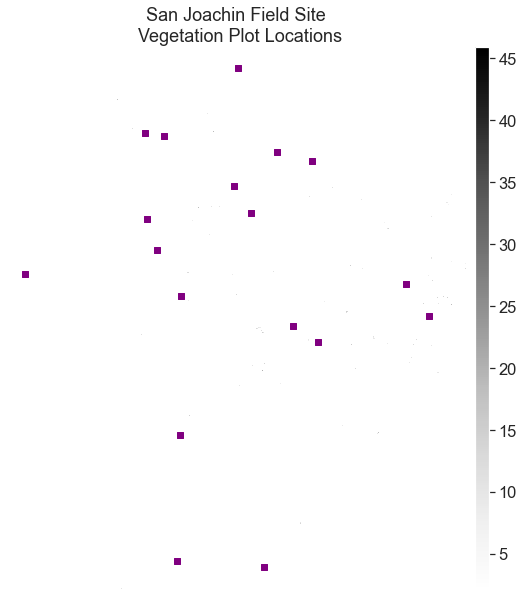

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(SJER_chm_data,
             extent=plotting_extent(sjer_lidar_chm_src),
             cmap="Greys",
             title="San Joachin Field Site \n Vegetation Plot Locations",
             scale=False,
             ax=ax)

SJER_plots_points.plot(ax=ax,
                      marker="s",
                      markersize=45,
                      color="purple")

ax.set_axis_off()
plt.show()

## Create a buffer around each plot point location

Each point in your data represent the centre location of a plot where trees were measured. You want to extract tree height values derived from the Lidar data for the entire plot. To do this, you will need to create a BUFFER around the points representing the region of the plot where data were collected.

In this case, your plot size is 40m. If you create a circular buffer with a 20m diameter, it will closely approximate where trees were measured on the ground.

You can use the .buffer() method to create the buffer. Here the buffer size is specified in the () of the function. You will send the new object to a new shp using .to_file() as follows:

SJER_plots.buffer(20).to_file("path-to-shapefile-here.shp")

![buffer-circular](buffer-circular.png)

Below you:
1. Make a copy of the points layer that will become a new polygon layer.
2. Buffer the points layer using the .buffer() method. This will produce a circle around each point that is x units radius. The units will coincide with the CRS of your data. This is known as a buffer.
3. When you perform the buffer, you UPDATE the "geometry" column of your new poly layer with the buffer output.

In [21]:
# Create a buffered polygon layer form your plot location points
SJER_plots_poly = SJER_plots_points.copy()

# Buffer each point using a 20m circule radius
# and replace the point geometry with the new buffered geometry
SJER_plots_poly["geometry"] = SJER_plots_points.geometry.buffer(20)
SJER_plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.280 4..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.871 4..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.760 4110819.876, 256858.664 4..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.851 4..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.276 4..."


Finally, export the buffered layer as a new shapefile. You will use this layer when you use the zonalstats function. Below you first check to ensure the outputs dir exists that you wish to write your data to. Then you export the data using the to_file method.

In [22]:
# If the dir does not exist, create it
output_path = os.path.join("data", "spatial-vector-lidar", "outputs")

if not os.path.isdir(output_path):
    os.mkdir(output_path)
    
# Export the buffered point layer as a shp to use in zonal stats
plot_buffer_path = os.path.join(output_path, "plot_buffer.shp")
SJER_plots_poly.to_file(plot_buffer_path)

## Extract pixel values for each plot

Once you have the boundary for each plot location (a 20m diameter circle) you can extract all of the pixels that fall within each circle using the function zonal_stats in the rasterstats library.

There are several ways to use the zonal_stats function. In this case we are providing the following
1. chm data (numpy array): SJER_chm_data in a numpy array format
2. Becaause a numpy array has no spatial information, you provide the affine data which is the spatial info needed to spatially locate the array.
3. plot_buffer_path: this is the path to the buffered point shp that you created at the top of this lesson

In [23]:
# Extract zonal stats
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                  SJER_chm_data,
                                  nodata=-999,
                                  affine=sjer_chm_meta["transform"],
                                  geojson_out=True,
                                  copy_properties=True,
                                  stats="count min mean max median")

# View object type
type(sjer_tree_heights)

list

Convert the list output to a geodataframe that you can plot the data.

In [24]:
# Turn extracted data into a pandas geodataframe
SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
SJER_lidar_height_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,min,max,mean,count,median
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,2.04,19.049999,11.544348,161,12.62
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,2.10,24.019999,10.369277,443,7.87
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,2.82,16.070000,7.518398,643,6.80
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,3.24,11.059999,7.675347,245,7.93
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,3.38,5.740000,4.591176,17,4.45


Below is a barplot of max Lidar derived tree height by plot id. This plot allows you to see how vegetation height varies across the field sites.

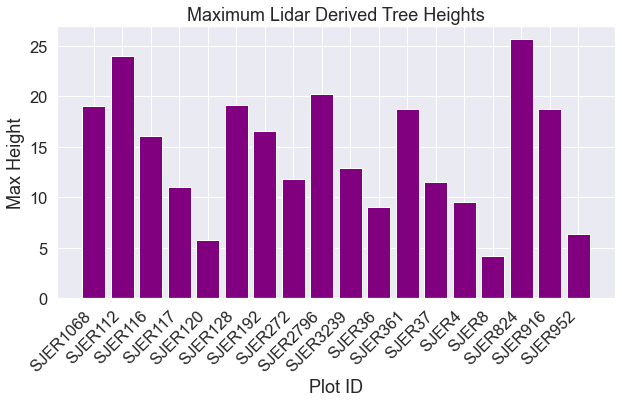

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(SJER_lidar_height_df["Plot_ID"],
      SJER_lidar_height_df["max"],
      color="purple")

ax.set(xlabel="Plot ID", ylabel="Max Height",
      title="Maximum Lidar Derived Tree Heights")

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()

## Explore the data distribution

If you want to explore the data distribution of pixel height values in each plot, rasterstats includes the datapoints corresponding to each zone. To access this, we included the raster_out keyword argument when we calculated the raster stats.

The raster_out argument creates a small raster with just the pixel values for each individual plot. You can then plot a histogram of each plot to assess the distribution of data values. This step is helpful if you need to further explore your data to identify potential issues or to better understand what is going on in the data.

Below you loop through the points included in each zone and show a histogram of its values. Note that each set of points is stored as a masked array. This is because images must be shaped as squares, where our zone may be any shape that we wish. This mask tells us which pixels fall into the zone.

In [27]:
# Extract zonal stats but retain the individual pixel values
sjer_tree_heights_ras = rs.zonal_stats(plot_buffer_path,
                                      SJER_chm_data,
                                      nodata=-999,
                                      affine=sjer_chm_meta["transform"],
                                      geojson_out=True,
                                      raster_out=True,
                                      copy_properties=True,
                                      stats="count min mean max median")

# Convert to geodataframe
SJER_lidar_height_df_ras = gpd.GeoDataFrame.from_features(
    sjer_tree_heights_ras)

# View subset of the dataframe
SJER_lidar_height_df_ras[["Plot_ID", "count", "geometry",
                          "mini_raster_affine", "mini_raster_array"]].head()

,Plot_ID,count,geometry,mini_raster_affine,mini_raster_array
0,SJER1068,161,"POLYGON ((255872.376 4111567.818, 255872.280 4...","(1.0, 0.0, 255832.0, 0.0, -1.0, 4111588.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
1,SJER112,443,"POLYGON ((257426.967 4111298.971, 257426.871 4...","(1.0, 0.0, 257386.0, 0.0, -1.0, 4111319.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
2,SJER116,643,"POLYGON ((256858.760 4110819.876, 256858.664 4...","(1.0, 0.0, 256818.0, 0.0, -1.0, 4110840.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
3,SJER117,245,"POLYGON ((256196.947 4108752.026, 256196.851 4...","(1.0, 0.0, 256156.0, 0.0, -1.0, 4108773.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."
4,SJER120,17,"POLYGON ((255988.372 4110476.079, 255988.276 4...","(1.0, 0.0, 255948.0, 0.0, -1.0, 4110497.0, 0.0...","[[--, --, --, --, --, --, --, --, --, --, --, ..."


Below you create a plot for each individual field site of all pixel values using earthpy.

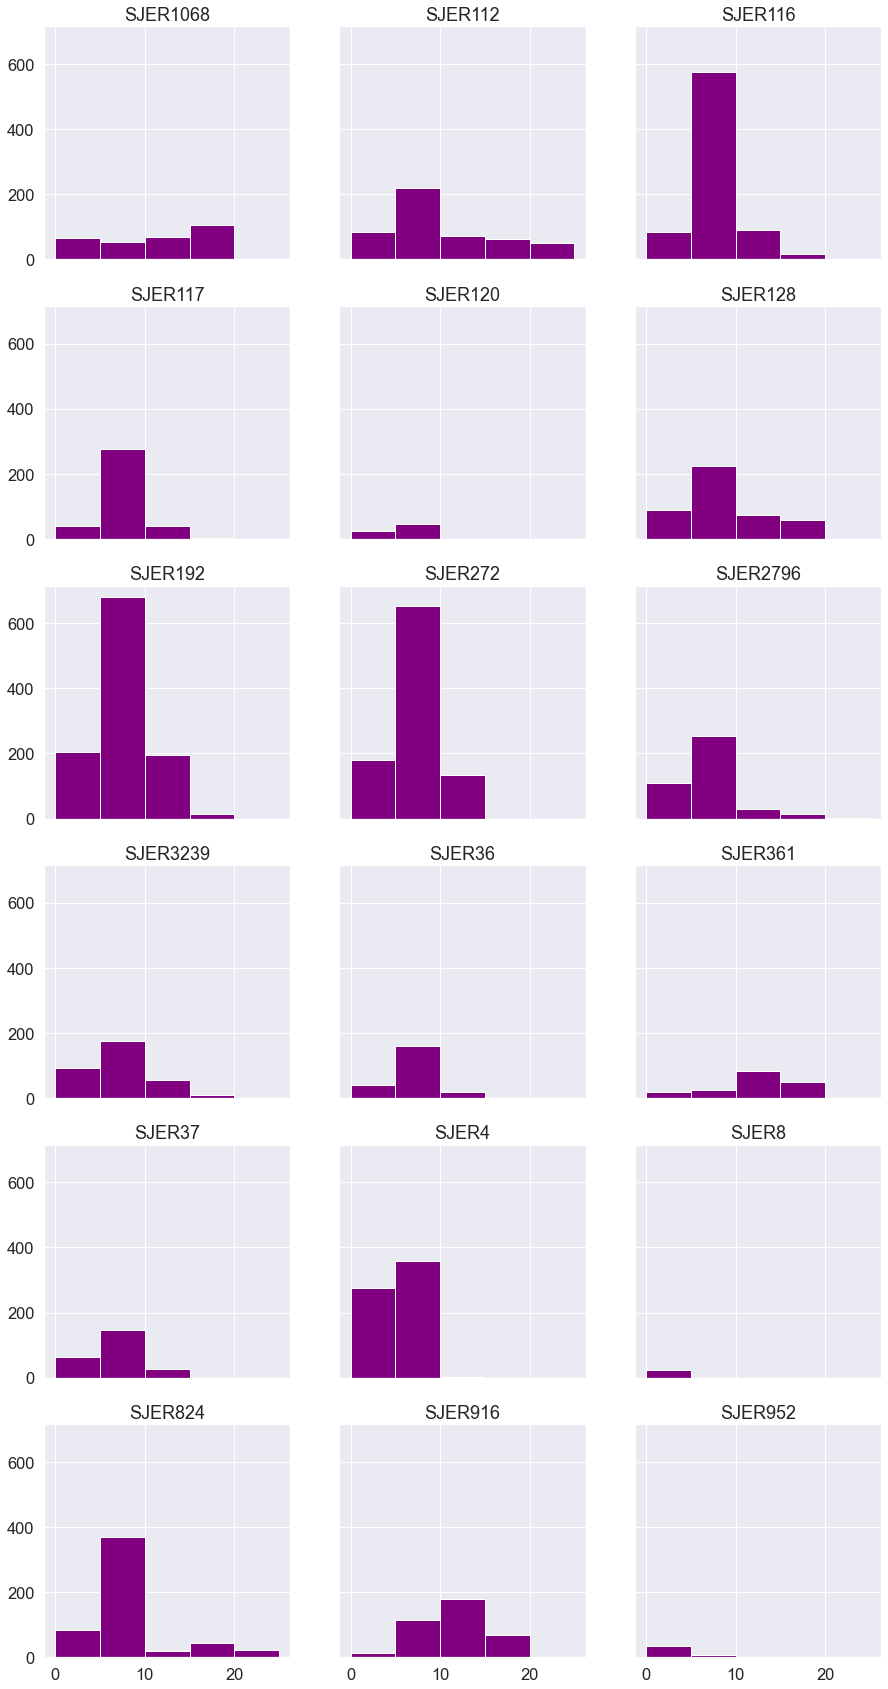

In [28]:
# Get list of sites
site_names = list(SJER_lidar_height_df_ras["Plot_ID"])

# Convert data in dataframe to a numpy array
arr = np.stack(SJER_lidar_height_df_ras["mini_raster_array"])

# Plot using earthpy
ep.hist(arr,
       bins=[0, 5, 10, 15, 20, 25],
       cols=3,
       title=site_names, figsize=(15, 30))

plt.show()